<a href="https://colab.research.google.com/github/anna4j/Knight-ML/blob/master/Knight_ML.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [0]:
%tensorflow_version 2.x
import tensorflow as tf
device_name = tf.test.gpu_device_name()
if device_name != '/device:GPU:0':
  raise SystemError('GPU device not found')
print('Found GPU at: {}'.format(device_name))

Found GPU at: /device:GPU:0


In [0]:
#a = []
#while(1):
 #   a.append('1')

In [0]:
import os
import matplotlib.pyplot as plt
import pandas as pd
import numpy as np
import seaborn as sns
from sklearn.preprocessing import LabelEncoder 
import nltk
from sklearn.model_selection import train_test_split
from keras.models import Sequential
from keras.layers import Dense
from keras.preprocessing.sequence import pad_sequences
from keras.layers import Dense, Embedding, LSTM, SpatialDropout1D
from sklearn.model_selection import train_test_split
from keras.utils.np_utils import to_categorical
from keras.callbacks import EarlyStopping
from keras.layers import Dropout

from keras.preprocessing.text import Tokenizer



%matplotlib inline

In [0]:
#Loading the data...

url_train = 'https://github.com/anna4j/Knight-ML/blob/master/Data/train.csv?raw=true'
df = pd.read_csv(url_train)

url_test = 'https://github.com/anna4j/Knight-ML/blob/master/Data/test.csv?raw=true'
test = pd.read_csv(url_test)



In [0]:
df.head()

,user_name,country,review_title,review_description,designation,points,price,province,region_1,region_2,winery,variety
0,NaN,Australia,Andrew Peace 2007 Peace Family Vineyard Chardo...,"Classic Chardonnay aromas of apple, pear and h...",Peace Family Vineyard,83,10.0,Australia Other,South Eastern Australia,NaN,Andrew Peace,Chardonnay
1,@wawinereport,US,North by Northwest 2014 Red (Columbia Valley (...,This wine is near equal parts Syrah and Merlot...,NaN,89,15.0,Washington,Columbia Valley (WA),Columbia Valley,North by Northwest,Red Blend
2,NaN,Italy,Renato Ratti 2007 Conca (Barolo),Barolo Conca opens with inky dark concentratio...,Conca,94,80.0,Piedmont,Barolo,NaN,Renato Ratti,Nebbiolo
3,@vossroger,France,Domaine l'Ancienne Cure 2010 L'Abbaye White (B...,It's impressive what a small addition of Sauvi...,L'Abbaye,87,22.0,Southwest France,Bergerac Sec,NaN,Domaine l'Ancienne Cure,Bordeaux-style White Blend
4,@vossroger,France,Château du Cèdre 2012 Le Cèdre Vintage Malbec ...,"This ripe, sweet wine is rich and full of drie...",Le Cèdre Vintage,88,33.0,France Other,Vin de Liqueur,NaN,Château du Cèdre,Malbec


In [0]:
#checking for missing values in the dataset..
df.isnull().sum()


user_name             19393
country                  35
review_title              0
review_description        0
designation           23647
points                    0
price                  5569
province                 35
region_1              12754
region_2              46708
winery                    0
variety                   0
dtype: int64

In [0]:
#These are the unique wine labels that we need to predict.
df['variety'].unique()



array(['Chardonnay', 'Red Blend', 'Nebbiolo',
       'Bordeaux-style White Blend', 'Malbec', 'Cabernet Sauvignon',
       'Zinfandel', 'Pinot Noir', 'Sauvignon Blanc', 'Gamay',
       'Grüner Veltliner', 'Bordeaux-style Red Blend', 'Sangiovese',
       'Syrah', 'White Blend', 'Cabernet Franc', 'Portuguese Red',
       'Portuguese White', 'Rhône-style Red Blend', 'Rosé',
       'Champagne Blend', 'Merlot', 'Riesling', 'Sparkling Blend',
       'Pinot Grigio', 'Tempranillo', 'Pinot Gris', 'Gewürztraminer'],
      dtype=object)

In [0]:
variety = df['variety']
description = df['review_description']
print ('There are %d varieties of wines in this dataset' % len(set(variety)))


There are 28 varieties of wines in this dataset


In [0]:
nltk.download('stopwords')

[nltk_data] Downloading package stopwords to /root/nltk_data...
[nltk_data]   Package stopwords is already up-to-date!


True

In [0]:
#converting to lower-case
df['review_description'] = df['review_description'].apply(lambda x: " ".join(x.lower() for x in x.split()))
df['review_description'].head()

0    classic chardonnay aromas of apple, pear and h...
1    this wine is near equal parts syrah and merlot...
2    barolo conca opens with inky dark concentratio...
3    it's impressive what a small addition of sauvi...
4    this ripe, sweet wine is rich and full of drie...
Name: review_description, dtype: object

In [0]:
#Removing Puntuation and bad symbols

df['review_description'] = df['review_description'].str.replace('[/(){}\[\]\|@,;:.""'']','')
df['review_description'] = df['review_description'].str.replace('[^0-9a-z #+%$!&*=_<>?]]','')

df['review_description'].head()

0    classic chardonnay aromas of apple pear and ha...
1    this wine is near equal parts syrah and merlot...
2    barolo conca opens with inky dark concentratio...
3    it's impressive what a small addition of sauvi...
4    this ripe sweet wine is rich and full of dried...
Name: review_description, dtype: object

In [0]:
#removal of stop words
from nltk.corpus import stopwords
stop = stopwords.words('english')
df['review_description'] = df['review_description'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
df['review_description'].head()


0    classic chardonnay aromas apple pear hay lead ...
1    wine near equal parts syrah merlot balance cab...
2    barolo conca opens inky dark concentration soo...
3    impressive small addition sauvignon gris musca...
4    ripe sweet wine rich full dried fresh fruit fl...
Name: review_description, dtype: object

In [0]:
#freq = pd.Series(' '.join(df['review_description']).split()).value_counts()[-50:]
#freq

In [0]:
#removing rare words

freq = list(freq.index)
df['review_description'] = df['review_description'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))


In [0]:
nltk.download('wordnet')


[nltk_data] Downloading package wordnet to /root/nltk_data...
[nltk_data]   Package wordnet is already up-to-date!


True

In [0]:
#lemmatization
from textblob import Word
df['review_description'] = df['review_description'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))
df['review_description'].head()

0    classic chardonnay aroma apple pear hay lead p...
1    wine near equal part syrah merlot balance cabe...
2    barolo conca open inky dark concentration soot...
3    impressive small addition sauvignon gris musca...
4    ripe sweet wine rich full dried fresh fruit fl...
Name: review_description, dtype: object

In [0]:
col = ['variety', 'review_description']
df = df[col]
df.columns = ['variety', 'review_description']
df['category_id'], label = pd.factorize(df['variety'])
from io import StringIO
category_id_df = df[['variety', 'category_id']].drop_duplicates().sort_values('category_id')
category_to_id = dict(category_id_df.values)
id_to_category = dict(category_id_df[['category_id', 'variety']].values)

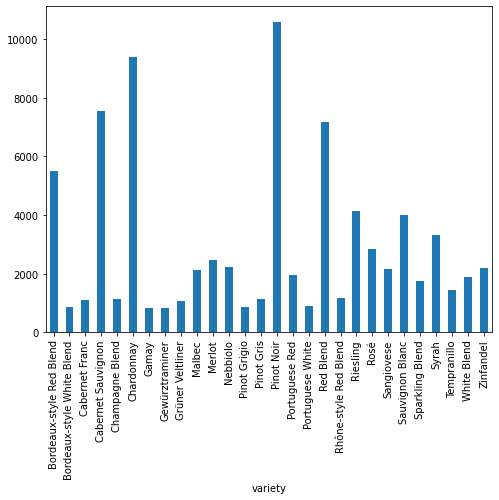

In [0]:
import matplotlib.pyplot as plt
fig = plt.figure(figsize=(8,6))
df.groupby('variety').review_description.count().plot.bar(ylim=0)
plt.show()

In [0]:
#from sklearn.feature_extraction.text import TfidfVectorizer

#tfidf = TfidfVectorizer(sublinear_tf=True, min_df=5, norm='l2', encoding='latin-1', ngram_range=(1, 2), stop_words='english')
#features = tfidf.fit_transform(df.review_description)



In [0]:
countVectorizer = CountVectorizer()
input_data = countVectorizer.fit_transform(df['review_description'])
labels = df.category_id

In [0]:
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier
from sklearn.naive_bayes import MultinomialNB
from sklearn.svm import LinearSVC

from sklearn.model_selection import cross_val_score


models = [
    RandomForestClassifier(n_estimators=200, max_depth=3, random_state=0),
    LinearSVC(),
    MultinomialNB(),
    LogisticRegression(random_state=0),
]
CV = 5
cv_df = pd.DataFrame(index=range(CV * len(models)))
entries = []
for model in models:
  model_name = model.__class__.__name__
  accuracies = cross_val_score(model, input_data, labels, scoring='accuracy', cv=CV)
  for fold_idx, accuracy in enumerate(accuracies):
    entries.append((model_name, fold_idx, accuracy))
cv_df = pd.DataFrame(entries, columns=['model_name', 'fold_idx', 'accuracy'])

/usr/local/lib/python3.6/dist-packages/sklearn/svm/_base.py:947: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)
/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://sci

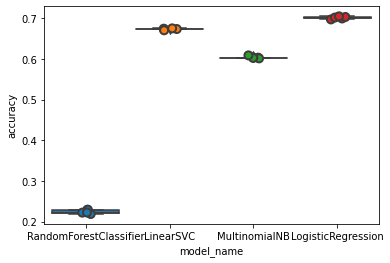

In [0]:
import seaborn as sns

sns.boxplot(x='model_name', y='accuracy', data=cv_df)
sns.stripplot(x='model_name', y='accuracy', data=cv_df, 
              size=8, jitter=True, edgecolor="gray", linewidth=2)
plt.show()

In [0]:
cv_df.groupby('model_name').accuracy.mean()


model_name
LinearSVC                 0.673022
LogisticRegression        0.700957
MultinomialNB             0.603651
RandomForestClassifier    0.224579
Name: accuracy, dtype: float64

In [0]:
from sklearn.model_selection import train_test_split

model = LogisticRegression()

X_train, X_test, y_train, y_test, indices_train, indices_test = train_test_split(input_data, labels, df.index, test_size=0.33, random_state=0)
model.fit(X_train, y_train)
y_pred = model.predict(X_test)

/usr/local/lib/python3.6/dist-packages/sklearn/linear_model/_logistic.py:940: ConvergenceWarning: lbfgs failed to converge (status=1):
STOP: TOTAL NO. of ITERATIONS REACHED LIMIT.

Increase the number of iterations (max_iter) or scale the data as shown in:
    https://scikit-learn.org/stable/modules/preprocessing.html
Please also refer to the documentation for alternative solver options:
    https://scikit-learn.org/stable/modules/linear_model.html#logistic-regression
  extra_warning_msg=_LOGISTIC_SOLVER_CONVERGENCE_MSG)


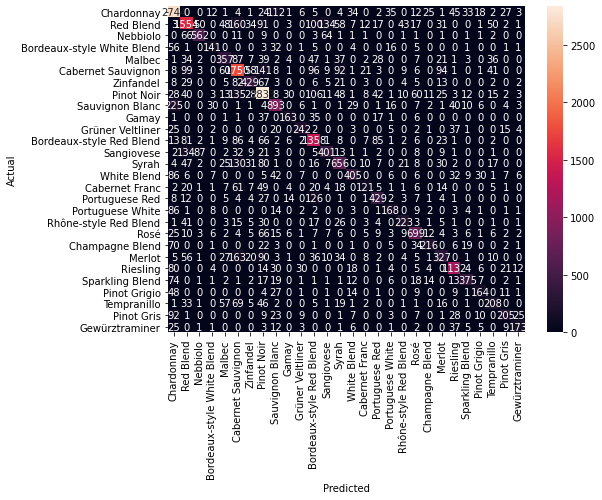

In [0]:
from sklearn.metrics import confusion_matrix

conf_mat = confusion_matrix(y_test, y_pred)
fig, ax = plt.subplots(figsize=(8,6))
sns.heatmap(conf_mat, annot=True, fmt='d',
            xticklabels=category_id_df.variety.values, yticklabels=category_id_df.variety.values)
plt.ylabel('Actual')
plt.xlabel('Predicted')
plt.show()

In [0]:
from sklearn import metrics
print(metrics.classification_report(y_test, y_pred, 
                                    target_names=df['variety'].unique()))

                            precision    recall  f1-score   support

                Chardonnay       0.74      0.87      0.80      3151
                 Red Blend       0.69      0.64      0.66      2416
                  Nebbiolo       0.78      0.78      0.78       725
Bordeaux-style White Blend       0.65      0.53      0.58       267
                    Malbec       0.57      0.50      0.53       716
        Cabernet Sauvignon       0.63      0.70      0.66      2502
                 Zinfandel       0.66      0.63      0.64       684
                Pinot Noir       0.75      0.82      0.78      3476
           Sauvignon Blanc       0.70      0.70      0.70      1281
                     Gamay       0.70      0.62      0.66       262
          Grüner Veltliner       0.78      0.67      0.72       359
  Bordeaux-style Red Blend       0.68      0.77      0.72      1766
                Sangiovese       0.61      0.55      0.58       732
                     Syrah       0.63      0.60

In [0]:
pred = model.predict(countVectorizer.transform(["If you like your white wines on the sugary sweet side, this one's for you. Shows classic GewÃ¼rz spiciness, with ripe tangerine, apricot, peach and honeysuckle flavors, and the acidity is just fine. The alcohol is a modest 12.5%."]))
label[pred]

Index(['Chardonnay'], dtype='object')

,user_name,country,review_title,review_description,designation,points,price,province,region_1,region_2,winery
0,@paulgwine,US,Boedecker Cellars 2011 Athena Pinot Noir (Will...,Nicely differentiated from the companion Stewa...,Athena,88,35.0,Oregon,Willamette Valley,Willamette Valley,Boedecker Cellars
1,@wineschach,Argentina,Mendoza Vineyards 2012 Gran Reserva by Richard...,"Charred, smoky, herbal aromas of blackberry tr...",Gran Reserva by Richard Bonvin,90,60.0,Mendoza Province,Mendoza,NaN,Mendoza Vineyards
2,@vboone,US,Prime 2013 Chardonnay (Coombsville),"Slightly sour and funky in earth, this is a re...",NaN,87,38.0,California,Coombsville,Napa,Prime
3,@wineschach,Argentina,Bodega Cuarto Dominio 2012 Chento Vineyard Sel...,"This concentrated, midnight-black Malbec deliv...",Chento Vineyard Selection,91,20.0,Mendoza Province,Mendoza,NaN,Bodega Cuarto Dominio
4,@kerinokeefe,Italy,SassodiSole 2012 Brunello di Montalcino,"Earthy aromas suggesting grilled porcini, leat...",NaN,90,49.0,Tuscany,Brunello di Montalcino,NaN,SassodiSole


In [0]:
#prediction

test['review_description'] = test['review_description'].apply(lambda x: " ".join(x.lower() for x in x.split()))
test['review_description'] = test['review_description'].str.replace('[/(){}\[\]\|@,;:.""'']','')
test['review_description'] = test['review_description'].str.replace('[^0-9a-z #+%$!&*=_<>?]]','')
test['review_description'] = test['review_description'].apply(lambda x: " ".join(x for x in x.split() if x not in stop))
test['review_description'] = test['review_description'].apply(lambda x: " ".join(x for x in x.split() if x not in freq))
test['review_description'] = test['review_description'].apply(lambda x: " ".join([Word(word).lemmatize() for word in x.split()]))


In [0]:
prediction = model.predict(countVectorizer.transform(test['review_description']), n_features)

ValueError: ignored